## Импорт библиотек

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import re
import glob
from glob import glob

import torch
from IPython.display import Image  
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import PIL

from random import shuffle
import cv2



## Предобработка данных для формата yolov5

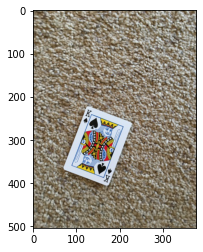

In [2]:
def show_image(path):
    random_detection_image = Image.open(path)
    plt.imshow(np.array(random_detection_image))
    plt.show()
    
show_image('../input/cards-detection/images/train/IMG_2388.JPG')

In [3]:
train_labels = pd.read_csv('../input/cards-detection/images/train_labels.csv')
test_labels = pd.read_csv('../input/cards-detection/images/test_labels.csv')

In [4]:
train_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cam_image1.jpg,480,270,queen,173,24,260,137
1,cam_image1.jpg,480,270,queen,165,135,253,251
2,cam_image1.jpg,480,270,ten,255,96,337,208
3,cam_image10.jpg,960,540,ten,501,116,700,353
4,cam_image10.jpg,960,540,queen,261,124,453,370


In [5]:
print('train labels:', sorted(train_labels['class'].unique()))
print('test labels:', sorted(test_labels['class'].unique()))

train labels: ['ace', 'jack', 'king', 'nine', 'queen', 'ten']
test labels: ['ace', 'jack', 'king', 'nine', 'queen', 'ten']


In [6]:
print(train_labels['class'].value_counts(), '\n')
print(test_labels['class'].value_counts())

king     95
ace      92
nine     89
jack     89
ten      82
queen    80
Name: class, dtype: int64 

nine     26
ace      26
queen    26
jack     24
king     23
ten      18
Name: class, dtype: int64


In [7]:
TARGETS = {i: j for i, j in zip(['ace', 'jack', 'king', 'nine', 'queen', 'ten'], range(6))}
print(TARGETS)

{'ace': 0, 'jack': 1, 'king': 2, 'nine': 3, 'queen': 4, 'ten': 5}


In [8]:
def get_yolo_format(data_init):
    data = data_init.copy()
    data['x_c'] = ( ((data['xmax'] + data['xmin']) / 2) / data['width'] ).apply(lambda x: max(0, min(1, x)))
    data['y_c'] = ( ((data['ymax'] + data['ymin']) / 2) / data['height']).apply(lambda x: max(0, min(1, x)))
    data['width_box'] = ((data['xmax'] - data['xmin']) / data['width']).apply(lambda x: max(0, min(1, x)))
    data['height_box'] = ((data['ymax'] - data['ymin']) / data['height']).apply(lambda x: max(0, min(1, x)))
    data['yolo'] = data.apply(lambda x: str(TARGETS[x['class']]) + ' ' 
                              + ' '.join([str(round(s, 4)) for s in x[-4:]]), axis=1)
    return data

In [9]:
train_labels = get_yolo_format(train_labels)
test_labels = get_yolo_format(test_labels)

In [10]:
train_labels['path'] = train_labels['filename'].apply(lambda x : '../input/cards-detection/images/train/' + x)
test_labels['path'] = test_labels['filename'].apply(lambda x : '../input/cards-detection/images/test/' + x)

In [11]:
train_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,x_c,y_c,width_box,height_box,yolo,path
0,cam_image1.jpg,480,270,queen,173,24,260,137,0.451042,0.298148,0.181250,0.418519,4 0.451 0.2981 0.1812 0.4185,../input/cards-detection/images/train/cam_imag...
1,cam_image1.jpg,480,270,queen,165,135,253,251,0.435417,0.714815,0.183333,0.429630,4 0.4354 0.7148 0.1833 0.4296,../input/cards-detection/images/train/cam_imag...
2,cam_image1.jpg,480,270,ten,255,96,337,208,0.616667,0.562963,0.170833,0.414815,5 0.6167 0.563 0.1708 0.4148,../input/cards-detection/images/train/cam_imag...
3,cam_image10.jpg,960,540,ten,501,116,700,353,0.625521,0.434259,0.207292,0.438889,5 0.6255 0.4343 0.2073 0.4389,../input/cards-detection/images/train/cam_imag...
4,cam_image10.jpg,960,540,queen,261,124,453,370,0.371875,0.457407,0.200000,0.455556,4 0.3719 0.4574 0.2 0.4556,../input/cards-detection/images/train/cam_imag...


In [12]:
train_labels_proc = train_labels[['filename', 'yolo', 'class', 'path']].rename(columns={'filename': 'id'})
test_labels_proc = test_labels[['filename', 'yolo', 'class', 'path']].rename(columns={'filename': 'id'})

In [13]:
!mkdir yolo_data yolo_data/train yolo_data/train/labels yolo_data/train/images

In [14]:
!mkdir yolo_data/val yolo_data/val/labels yolo_data/val/images

В файлах train_labels_proc и test_labels_proc содержится информация о bounding box для каждой картинки в нужном для yolo формате, теперь эта информация должна быть записана в файлах txt и располагаться в корректной папке. Ниже происходит запись в txt файлы и копирование картинок в новую корректную для yolov5 папку.

In [15]:
for image_file in tqdm(train_labels_proc.id.unique()):
    
    temp_ann = train_labels_proc[train_labels_proc.id == image_file]
    image = cv2.imread(temp_ann.path.iloc[0])
    
    s_ann = ''
    
    for i, val in temp_ann.iterrows():
        
        s_ann += val['yolo']
        if i != temp_ann.shape[0] - 1:
            s_ann += '\n'
    
    label_file = 'yolo_data/train/labels/'+image_file[:-4]+'.txt'
    image_file = 'yolo_data/train/images/'+image_file
    
    with open(label_file, 'w') as f:
        f.write(s_ann)
    
    cv2.imwrite(image_file, image)


100%|██████████| 296/296 [00:05<00:00, 58.10it/s]


In [16]:
for image_file in tqdm(test_labels_proc.id.unique()):
    
    temp_ann = test_labels_proc[test_labels_proc.id == image_file]
    image = cv2.imread(temp_ann.path.iloc[0])
    
    s_ann = ''
    
    for i, val in temp_ann.iterrows():
        
        s_ann += val['yolo']
        if i != temp_ann.shape[0] - 1:
            s_ann += '\n'
    
    label_file = 'yolo_data/val/labels/'+image_file[:-4]+'.txt'
    image_file = 'yolo_data/val/images/'+image_file
    
    with open(label_file, 'w') as f:
        f.write(s_ann)
    
    cv2.imwrite(image_file, image)


100%|██████████| 67/67 [00:01<00:00, 63.45it/s]


## Тренировка yolov5

Для тренировки используется реализация от ultralytics:

1. https://github.com/ultralytics/yolov5
1. https://docs.ultralytics.com/



In [17]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10606, done.
remote: Total 10606 (delta 0), reused 0 (delta 0), pack-reused 10606
Receiving objects: 100% (10606/10606), 10.84 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (7323/7323), done.


In [18]:
pip install -r yolov5/requirements.txt

Note: you may need to restart the kernel to use updated packages.


Создание yaml файла для сетки с информацией о расположении картинок, лейблов и классов

In [19]:
yaml_file = "yolov5/data/cards.yaml"
train_images_dir = os.path.join('..', 'yolo_data/train', 'images')
val_images_dir = os.path.join('..', 'yolo_data/val', 'images')

names_str = ''
for item in list(TARGETS.keys()):
    names_str = names_str + ", \'%s\'"%item
names_str = "names: ["+names_str[1:]+"]"

with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%len(list(TARGETS.keys())))
    wobj.write(names_str+"\n")

In [20]:
cat yolov5/data/cards.yaml

train: ../yolo_data/train/images
val: ../yolo_data/val/images
nc: 6
names: [ 'ace', 'jack', 'king', 'nine', 'queen', 'ten']


In [21]:
import wandb
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
!cd yolov5 && python train.py --img 512 --batch 16 --epochs 100 --data ../yolov5/data/cards.yaml --weights yolov5s.pt --name cards_detection

wandb: Currently logged in as: yuriy42 (use `wandb login --relogin` to force relogin)
github: up to date with https://github.com/ultralytics/yolov5 ✅
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.12.7
wandb: Syncing run cards_detection
wandb: ⭐️ View project at https://wandb.ai/yuriy42/YOLOv5
wandb: 🚀 View run at https://wandb.ai/yuriy42/YOLOv5/runs/1k88zq0p
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20220121_190716-1k88zq0p
wandb: Run `wandb offline` to turn off syncing.

100%|██████████████████████████████████████| 14.0M/14.0M [00:00<00:00, 51.3MB/s]

train: Scanning '../yolo_data/train/labels' images and labels...296 found, 0 mis
val: Scanning '../yolo_data/val/labels' images and labels...67 found, 0 missing,
      0/99     2.57G    0.1225    0.0284   0.05726        43       512: 100%|███
               Class     Images     Labels          P          R     mA

Полученные метрики и лоссы приведены в отчете. 

## Пример детекции

In [25]:
!cd yolov5 && python detect.py --weights runs/train/cards_detection/weights/best.pt --source ../yolo_data/val/images/

In [26]:
!ls yolov5/runs/detect/exp

IMG_2383.JPG  IMG_2476.JPG  IMG_2555.JPG  IMG_2595.JPG	IMG_2675.JPG
IMG_2384.JPG  IMG_2479.JPG  IMG_2557.JPG  IMG_2598.JPG	IMG_2677.JPG
IMG_2387.JPG  IMG_2482.JPG  IMG_2560.JPG  IMG_2600.JPG	IMG_2678.JPG
IMG_2391.JPG  IMG_2485.JPG  IMG_2561.JPG  IMG_2604.JPG	IMG_2686.JPG
IMG_2395.JPG  IMG_2510.JPG  IMG_2564.JPG  IMG_2634.JPG	cam_image2.jpg
IMG_2403.JPG  IMG_2530.JPG  IMG_2568.JPG  IMG_2636.JPG	cam_image4.jpg
IMG_2432.JPG  IMG_2531.JPG  IMG_2571.JPG  IMG_2639.JPG	cam_image45.jpg
IMG_2433.JPG  IMG_2532.JPG  IMG_2573.JPG  IMG_2640.JPG	cam_image5.jpg
IMG_2435.JPG  IMG_2539.JPG  IMG_2580.JPG  IMG_2647.JPG	cam_image6.jpg
IMG_2436.JPG  IMG_2540.JPG  IMG_2583.JPG  IMG_2651.JPG	cam_image7.jpg
IMG_2440.JPG  IMG_2544.JPG  IMG_2585.JPG  IMG_2654.JPG	cam_image8.jpg
IMG_2461.JPG  IMG_2550.JPG  IMG_2591.JPG  IMG_2656.JPG
IMG_2463.JPG  IMG_2551.JPG  IMG_2592.JPG  IMG_2662.JPG
IMG_2470.JPG  IMG_2554.JPG  IMG_2594.JPG  IMG_2670.JPG


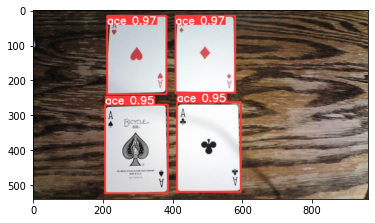

In [28]:
show_image('yolov5/runs/detect/exp/cam_image8.jpg')

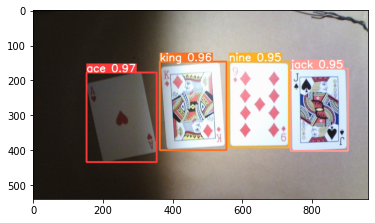

In [29]:
show_image('yolov5/runs/detect/exp/cam_image45.jpg')